In [1]:
import pandas as pd

data_df = pd.DataFrame()

for i in range(1,11):
    raw_data = pd.read_csv(f"./data/Borkowski et al. (2020)/plate_AL_{i}_raw_yield_and_std.csv")
    data_df = pd.concat([data_df, raw_data], ignore_index=True)

data_df.head()

,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,K_gluta,yield,yield_std
0,0.165,0.0204,0.078,0.75,0.3,9,0.45,0.02,1.2,0.375,40,0.0000,0.0131
1,0.330,0.0680,0.260,1.50,1.0,30,1.50,0.20,0.4,0.750,80,0.0000,0.0095
2,0.330,0.0680,0.260,0.15,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0770
3,0.330,0.0680,0.260,0.45,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0940
4,0.330,0.0680,0.260,1.50,1.0,30,0.15,0.20,4.0,0.750,80,0.0147,0.0233


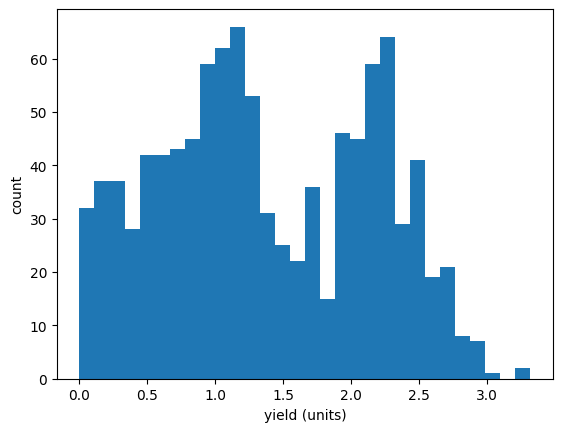

In [2]:
import matplotlib.pyplot as plt

# target
data_df['yield'].hist(bins=30)
plt.grid(False)
plt.xlabel('yield (units)')
plt.ylabel('count')
plt.show()

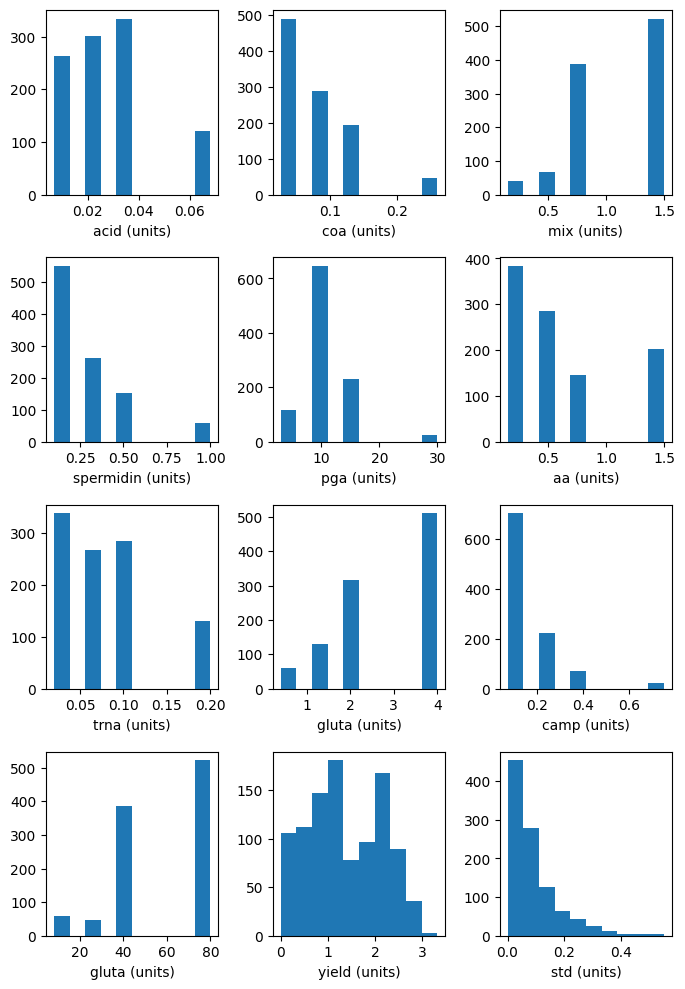

In [3]:
col_idx = 1
f, axes = plt.subplots(4, 3, figsize=(7,10))
axes = axes.ravel()
for ax in axes:
    ax.hist(data_df.iloc[:, col_idx])
    col_name = data_df.columns[col_idx].split('_')[-1]
    ax.set_xlabel(f'{col_name} (units)')
    col_idx+=1
plt.tight_layout()

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

def train_test_custom_split(X, y, test_split=0.20, seed=1):
    
    random.seed(seed)
    
    n_samples = len(X)//3
    rxn_numbers = list(X['Rxn.Number'].unique())
    
    n_test = int(test_split*n_samples)
    
    test_idx = random.sample(rxn_numbers, n_test)
    train_idx = [i for i in rxn_numbers if i not in test_idx]
    
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_test = pd.DataFrame()
    
    for idx in train_idx:
        sample_x, sample_y = X[X['Rxn.Number']==idx], y[y['Rxn.Number']==idx]

        X_train = X_train.append(sample_x)
        y_train = y_train.append(sample_y)
        
    for idx in test_idx:
        sample_x, sample_y = X[X['Rxn.Number']==idx], y[y['Rxn.Number']==idx]
        X_test = X_test.append(sample_x)
        y_test = y_test.append(sample_y)
        
    # check for data leakage
    assert set(X_test['Rxn.Number']).intersection(set(X_train['Rxn.Number'])) == set()
    
    # check for data loss
    assert len(X_train) + len(X_test) == n_samples*3
        
    return X_train, X_test, y_train, y_test

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X = data_df[['nad', 'folinic_acid', 'coa', 'nucleo_mix', 'spermidin', 'pga', 'aa',
       'trna', 'mg_gluta', 'camp', 'K_gluta']]
y = data_df[['yield']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1) 


y_train = np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)
y_test = np.array(y_test).reshape(-1)

x_scaler = StandardScaler() 
X_train_transformed = x_scaler.fit_transform(X_train)
X_val_transformed = x_scaler.transform(X_val)
X_test_transformed = x_scaler.transform(X_test)

y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)
y_scaler = StandardScaler() 
y_train_transformed = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_transformed = y_scaler.transform(y_val.reshape(-1, 1))
y_test_transformed = y_scaler.transform(y_test.reshape(-1, 1))

In [6]:
X_train_transformed.shape, y_train_transformed.shape, X_val_transformed.shape, y_val_transformed.shape, X_test_transformed.shape, y_test_transformed.shape

((813, 11), (813, 1), (204, 11), (204, 1), (204, 11), (204, 1))

In [7]:
# mean and std should be 0 and 1 after scaling
X_train_transformed.mean(), X_train_transformed.std(), y_train_transformed.mean(), y_train_transformed.std() 

(2.6467577865378884e-17, 1.0, 3.670700479941477e-16, 1.0)

# Predict yield

## linear model

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

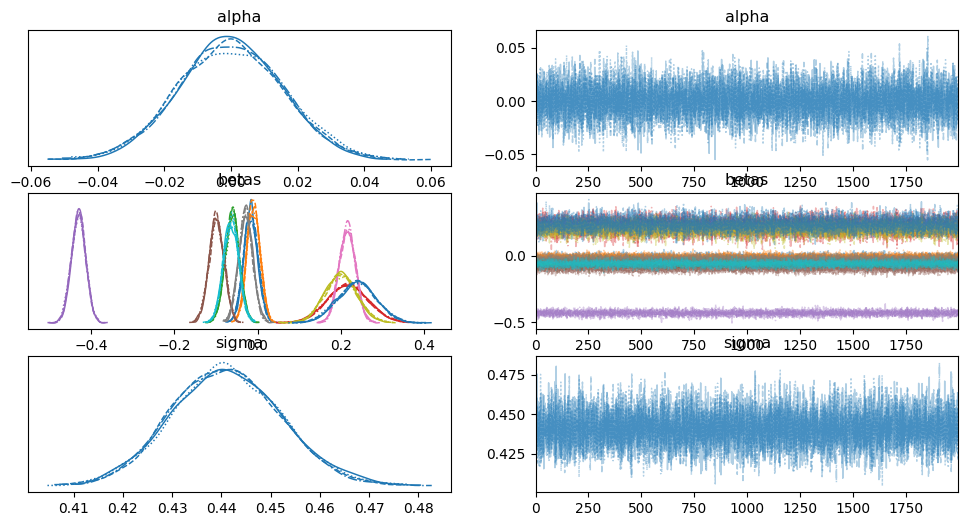

In [10]:
import pymc as pm
import arviz as az
import numpy as np

linear_model = pm.Model()

with linear_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=y_train_transformed.mean(), sigma=1)  # standardized response
    betas = pm.Normal("betas", mu=0, sigma=10, shape=X_train_transformed.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)  # positive std

    mu = alpha + pm.math.dot(betas, X_train_transformed.T)

    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y_train_transformed[:, 0])

    trace = pm.sample(2000, target_accept=0.9)

az.plot_trace(trace)


Sampling: [likelihood]


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

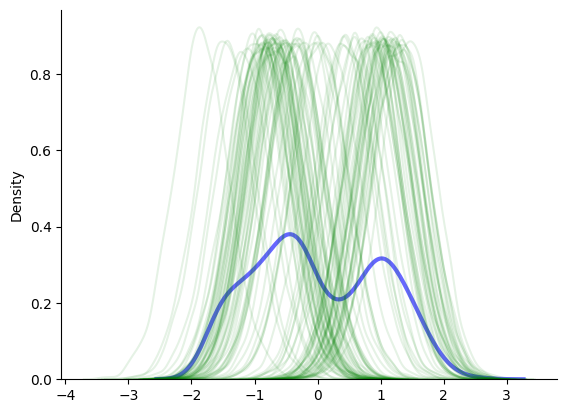

In [ ]:
import seaborn as sns
import arviz as az

ppc = pm.sample_posterior_predictive(trace, model=linear_model, var_names=["likelihood"])

y_pred_samples = ppc.posterior_predictive["likelihood"].stack(draws=("chain", "draw")).values

sns.kdeplot(y_train_transformed[:, 0], label="Observed", color="blue", lw=3, alpha=0.6)

for i in range(100):
    sns.kdeplot(y_pred_samples[i], color="green", alpha=0.1)

sns.despine()


In [13]:
# Extract posterior means
alpha_mp = trace.posterior['alpha'].mean().values
betas_mp = trace.posterior['betas'].mean(dim=["chain", "draw"]).values

alpha_mp, betas_mp

(array(-0.00010961),
 array([-0.01638292, -0.0096424 , -0.06070017,  0.21635384, -0.4301106 ,
        -0.09848417,  0.21559706, -0.02831777,  0.19966912, -0.06337566,
         0.23878298]))

In [14]:
# Compare against baseline linear regression model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_transformed, y_train_transformed[:,0])
reg.intercept_, reg.coef_

(3.594705712268439e-16,
 array([-0.016504  , -0.00973586, -0.06074336,  0.21724258, -0.43028737,
        -0.09833982,  0.21562165, -0.0285394 ,  0.19943721, -0.06318934,
         0.23839069]))

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats

mu = alpha_mp*len(y_train_transformed) + np.dot(betas_mp, X_train_transformed.T)
y_pred = y_scaler.inverse_transform(mu.reshape(-1, 1)).reshape(-1)

print("training set performance metrics")
print("r squared:", r2_score(y_train, y_pred))
print("MAE:", mean_absolute_error(y_train, y_pred))
rho = stats.spearmanr(y_train, y_pred)

print("rho:", rho.correlation, rho.pvalue)

training set performance metrics
r squared: 0.8009776934224238
MAE: 0.28576540637573167
rho: 0.866620007670741 4.433414512229906e-247


In [16]:
mu = alpha_mp*len(y_val_transformed) + np.dot(betas_mp, X_val_transformed.T)
y_pred = y_scaler.inverse_transform(mu.reshape(-1, 1)).reshape(-1)

print("held-out set performance metrics")
print("r squared:", r2_score(y_val, y_pred))
print("MAE:", mean_absolute_error(y_val, y_pred))

rho = stats.spearmanr(y_val, y_pred)

print("rho:", rho.correlation, rho.pvalue)

held-out set performance metrics
r squared: 0.7816887020290364
MAE: 0.29145122916239125
rho: 0.8690679047205914 1.1608525128219885e-63


## Gaussian process regression

The `gp.Marginal` class implements the more common case of GP regression: the observed data are the sum of a GP and Gaussian noise.

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats

In [22]:
import numpy as np
import pymc as pm
import pytensor.tensor as at

X = np.array(X_train_transformed)
y = np.array(y_train_transformed).reshape(-1)

with pm.Model() as model:
    
    # Priors for GP hyperparameters
    l = pm.Gamma('l', alpha=2, beta=0.5, shape=X.shape[1])
    
    log_s2_f = pm.Uniform('log_s2_f', lower=-2.0, upper=2.0)
    s2_f = pm.Deterministic('s2_f', at.exp(log_s2_f))

    # Covariance function for the GP prior
    cov_func = s2_f * pm.gp.cov.ExpQuad(input_dim=X.shape[1], ls=l)

    # GP prior
    gp = pm.gp.Marginal(cov_func=cov_func)

    log_s2_n = pm.Uniform('log_s2_n', lower=-2.0, upper=2.0)
    s2_n = pm.Deterministic('s2_n', at.exp(log_s2_n))

    # Marginal likelihood
    y_obs = gp.marginal_likelihood("y", X=X, y=y, noise=s2_n)

    # Sample from the posterior
    trace = pm.sample(2000, target_accept=0.9)


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Initializing NUTS using jitter+adapt_diag...
/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatc

/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_512 draw iterations (4_000 + 6_048 draws total) took 6914 seconds.


In [32]:
trace.posterior.sizes

Frozen({'chain': 4, 'draw': 1512, 'l_dim_0': 11})

In [ ]:
import pymc as pm
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats

with model:
    # Use GP's conditional method to define predictive distribution
    y_pred = gp.conditional("y_pred_train", X_train_transformed, pred_noise=True)

    # Draw posterior predictive samples
    y_pred_samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_pred_train"],
    )

y_samples = y_pred_samples.posterior_predictive["y_pred_train"].stack(sample=("chain", "draw")).values.T

mu_train = np.zeros(len(X_train_transformed))
sd_train = np.zeros(len(X_train_transformed))

for i in range(len(X_train_transformed)):
    y_inv_train = y_scaler.inverse_transform(y_samples[:, i].reshape(-1, 1)).reshape(-1)
    mu_train[i] = np.mean(y_inv_train)
    sd_train[i] = np.std(y_inv_train)

print("train set performance metrics")
print("r squared:", r2_score(y_train, mu_train))
print("MAE:", mean_absolute_error(y_train, mu_train))

rho = stats.spearmanr(y_train, mu_train)
print("rho:", rho.correlation, rho.pvalue)


val set performance metrics
r squared: 0.9480153718300253
MAE: 0.12676599841111694
rho: 0.9721637961280224 0.0


In [42]:
with model:
    y_pred = gp.conditional("y_pred_val1", X_val_transformed, pred_noise=True, shape=(X_val_transformed.shape[0],), jitter=1e-6)

    y_pred_samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_pred_val1"]
    )

y_samples = (y_pred_samples.posterior_predictive["y_pred_val1"].stack(sample=("chain", "draw")).values.T)

y_samples_inv = y_scaler.inverse_transform(y_samples.T).T 

mu_val = np.mean(y_samples_inv, axis=0)
sd_val = np.std(y_samples_inv, axis=0)

print("held-out set performance metrics")
print("r squared:", r2_score(y_val, mu_val))
print("MAE:", mean_absolute_error(y_val, mu_val))

rho = stats.spearmanr(y_val, mu_val)
print("rho:", rho.correlation, rho.pvalue)

Sampling: [y_pred_val1]


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

held-out set performance metrics
r squared: 0.9062830036548176
MAE: 0.1603933755946981
rho: 0.9502554581251063 2.7617781069713707e-104
rho: 0.9502554581251063 2.7617781069713707e-104


Train set performance metrics
R²: 0.9528178003267
MAE: 0.07720156924228588
Spearman rho: 0.9742045580102489 6.0352930796923995e-176

Held-out set performance metrics
R²: 0.9244043402198165
MAE: 0.102719829650977
Spearman rho: 0.9633545825857922 1.940219203330782e-39


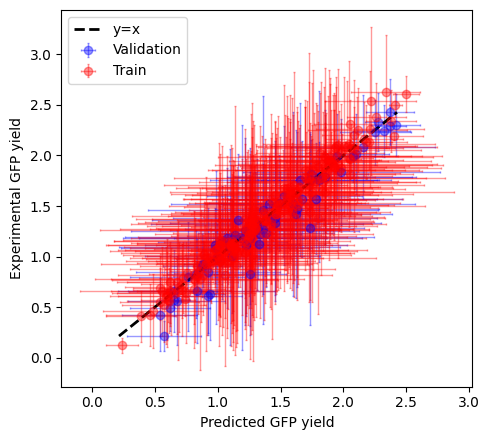

In [57]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt

def block_mean_std(arr):
    arr = np.array(arr)
    arr = arr[:len(arr) - len(arr) % 3]  # Trim to multiple of 3
    return np.mean(arr.reshape(-1, 3), axis=1), np.std(arr.reshape(-1, 3), axis=1)

# --- Validation set ---
y_val_mean, y_val_std = block_mean_std(y_val)
mu_val_blocked, sd_val_blocked = block_mean_std(mu_val)
assert len(y_val_mean) == len(mu_val_blocked)

# --- Training set ---
y_train_mean, y_train_std = block_mean_std(y_train)
mu_train_blocked, sd_train_blocked = block_mean_std(mu_train)
assert len(y_train_mean) == len(mu_train_blocked)

# --- Metrics: Train ---
print("Train set performance metrics")
print("R²:", r2_score(y_train_mean, mu_train_blocked))
print("MAE:", mean_absolute_error(y_train_mean, mu_train_blocked))
rho = stats.spearmanr(y_train_mean, mu_train_blocked)
print("Spearman rho:", rho.correlation, rho.pvalue)

# --- Metrics: Validation ---
print("\nHeld-out set performance metrics")
print("R²:", r2_score(y_val_mean, mu_val_blocked))
print("MAE:", mean_absolute_error(y_val_mean, mu_val_blocked))
rho = stats.spearmanr(y_val_mean, mu_val_blocked)
print("Spearman rho:", rho.correlation, rho.pvalue)

# --- Plot ---
plt.figure(figsize=(5, 4.5))

plt.errorbar(
    mu_val_blocked, y_val_mean,
    yerr=y_val_std, xerr=sd_val_blocked,
    fmt='o', color='blue', label='Validation',
    alpha=0.4,  # lighter error bars
    elinewidth=1, capsize=1
)

plt.errorbar(
    mu_train_blocked, y_train_mean,
    yerr=y_train_std, xerr=sd_train_blocked,
    fmt='o', color='red', label='Train',
    alpha=0.4,
    elinewidth=1, capsize=1
)

# add x=y
plt.plot([y_val_mean.min(), y_val_mean.max()], [y_val_mean.min(), y_val_mean.max()], 'k--', lw=2, label='y=x')
plt.xlabel('Predicted GFP yield')
plt.ylabel('Experimental GFP yield')
plt.legend()
plt.tight_layout()
plt.show()


### Feature importance

In [58]:
def feat_imp(x, y, var_name, small_good = True): 
    
    columns = ['nad', 'folinic_acid', 'coa', 'nucleo_mix', 'spermidin', 'pga', 'aa',
       'trna', 'mg_gluta', 'camp', 'K_gluta']
       
    score_list = {} 
    
    with model:
        y_pred = gp.conditional(var_name, x, pred_noise=True, shape=(x.shape[0],))
        y_pred_samples = pm.sample_posterior_predictive(trace, var_names=[var_name])

    mu = np.zeros(len(x))
    sd = np.zeros(len(x))

    for i in range(0,len(x),1):
        y_inv = y_scaler.inverse_transform(y_pred_samples[var_name][:,i].reshape(-1, 1)).reshape(-1)
        mu[i] = np.mean(y_inv)
        sd[i] = np.std(y_inv)
        
    score_list['original'] = r2_score(y, mu)
    print("original score: ", score_list['original'])
    
    imp = {} 
    for i in range(len(columns)): 
        rand_idx = np.random.permutation(len(x)) # randomization
        new_coli = x[rand_idx, i]
        new_x = x.copy() 
        new_x[:,i] = new_coli
        
        with model:
            y_pred = gp.conditional(var_name+str(i), new_x, pred_noise=True, shape=(x.shape[0],))
            y_pred_samples = pm.sample_posterior_predictive(trace, var_names=[var_name+str(i)])

        mu = np.zeros(len(new_x))
        sd = np.zeros(len(new_x))

        for k in range(0,len(x),1):
            y_inv = y_scaler.inverse_transform(y_pred_samples[var_name+str(i)][:,k].reshape(-1, 1)).reshape(-1)
            mu[k] = np.mean(y_inv)
            sd[k] = np.std(y_inv)
        
        score_list[columns[i]] = r2_score(y, mu)
        imp[columns[i]] = score_list['original'] - score_list[columns[i]] # comparison with benchmark

    if small_good: 
         return sorted(imp.items(), key=lambda x: x[1]) 
    else: return sorted(imp.items(), key=lambda x: x[1], reverse=True)

In [ ]:
feat_imp(X_test_transformed, y_test, 'y1', small_good = True)

Sampling: [y1]


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')